In [10]:
import os
import json
import pandas as pd

data = []

# Loop through all files in the Spark_test folder
for foldername, subfolders, filenames in os.walk('C:/Users/herre/Documents/Spark_test'):
    for filename in filenames:
        # Check if the file is a .file and starts with 'part-'
        if filename.startswith('part-'):
            filepath = os.path.join(foldername, filename)
            print(filepath)
            # Open the file and parse each line as a JSON object
            with open(filepath, 'r') as f:
                for line in f:
                    obj = json.loads(line)
                    # Extract the required fields and append to the data list
                    data.append({
                        'review_id': obj['review_id'],
                        'app_id': obj['app_id'],
                        'review_text': obj['review_text'],
                        'label': obj['label']
                    })

# Convert the data list to a pandas dataframe
df = pd.DataFrame(data, columns=['review_id', 'app_id', 'review_text', 'label'])


C:/Users/herre/Documents/Spark_test\Data-1682435260000\part-00000
C:/Users/herre/Documents/Spark_test\Data-1682435260000\part-00001
C:/Users/herre/Documents/Spark_test\Data-1682435260000\part-00002
C:/Users/herre/Documents/Spark_test\Data-1682435260000\part-00003
C:/Users/herre/Documents/Spark_test\Data-1682435280000\part-00000
C:/Users/herre/Documents/Spark_test\Data-1682435280000\part-00001
C:/Users/herre/Documents/Spark_test\Data-1682435280000\part-00002
C:/Users/herre/Documents/Spark_test\Data-1682435280000\part-00003
C:/Users/herre/Documents/Spark_test\Data-1682435280000\part-00004
C:/Users/herre/Documents/Spark_test\Data-1682435280000\part-00005
C:/Users/herre/Documents/Spark_test\Data-1682435320000\part-00000
C:/Users/herre/Documents/Spark_test\Data-1682435320000\part-00001
C:/Users/herre/Documents/Spark_test\Data-1682435320000\part-00002
C:/Users/herre/Documents/Spark_test\Data-1682435320000\part-00003
C:/Users/herre/Documents/Spark_test\Data-1682435320000\part-00004
C:/Users/h

In [13]:
df

,review_id,app_id,review_text,label,length
0,137272710,1679290,I need to praise the effort put into the art d...,0,1841
1,137272945,1663220,"Long as I play to the end, this story still go...",1,92
2,137274382,1816950,[h1]More interesting reviews on [url=https://s...,1,2197
3,137274860,2281730,mw rip off 💀 \n,1,15
4,137274157,2281730,"Puede que sea una copia de warzone, pero a mi ...",1,650
...,...,...,...,...,...
246,137985561,2311190,I am the ban ban 3,0,18
247,137985414,2251380,It's Subway Surfers except you're in Russia. T...,1,116
248,137985043,2251380,10/10,1,5
249,137985988,1742020,Fighting game but I get to play as a big titty...,1,122


In [12]:
# add column length of review
df['length'] = df['review_text'].str.len()

In [24]:
import numpy as np
np.mean(df['label'])

0.7729083665338645

<Axes: title={'center': 'length'}, xlabel='label'>

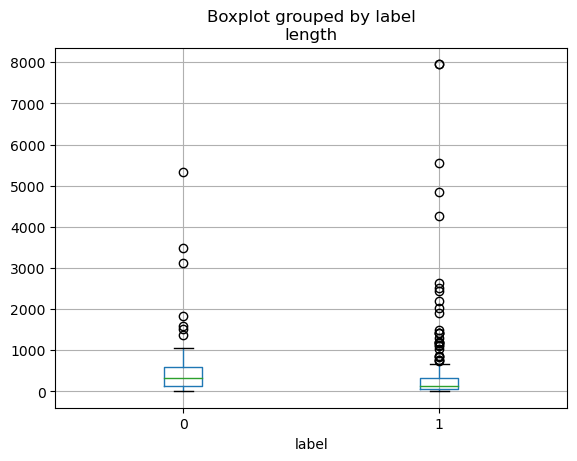

In [14]:
# plot label against length boxplot
df.boxplot(column='length', by='label')

In [30]:
!pip install transformers
!pip install torch
import os
import json
import pandas as pd
import torch
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, BertTokenizer, AdamW

# Load the data from the JSON files
data = []
for foldername, subfolders, filenames in os.walk('C:/Users/herre/Documents/Spark_test'):
    for filename in filenames:
        if filename.startswith('part-'):
            filepath = os.path.join(foldername, filename)
            with open(filepath, 'r') as f:
                for line in f:
                    obj = json.loads(line)
                    data.append(obj)

# Convert the data to a pandas dataframe
df = pd.DataFrame(data)

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Load the pre-trained BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the review text and convert it to features
X_train = train_df['review_text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
X_test = test_df['review_text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
max_len = 0
for i in X_train.values:
    if len(i) > max_len:
        max_len = len(i)
for i in X_test.values:
    if len(i) > max_len:
        max_len = len(i)
X_train = torch.tensor(pad_sequences(X_train, maxlen=max_len, dtype="long", value=0, truncating="post", padding="post"))
X_test = torch.tensor(pad_sequences(X_test, maxlen=max_len, dtype="long", value=0, truncating="post", padding="post"))
y_train = torch.tensor(train_df['label'].values)
y_test = torch.tensor(test_df['label'].values)

# Create a DataLoader object to feed the data to the model
batch_size = 32
train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_sampler = torch.utils.data.SequentialSampler(test_data)
test_dataloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Set the hyperparameters for fine-tuning the model
learning_rate = 2e-5
epochs = 4

# Set the optimizer and learning rate scheduler for the model
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Fine-tune the model on the training data
for epoch in range(epochs):
    for step, batch in enumerate(train_dataloader):
        model.train()
        batch_X, batch_y = batch
        optimizer.zero_grad()
        outputs = model(batch_X, token_type_ids=None, attention_mask=(batch_X > 0).to(torch.long), labels=batch_y)
        loss = outputs[0]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()


  Using cached transformers-4.28.1-py3-none-any.whl (7.0 MB)
  Using cached filelock-3.12.0-py3-none-any.whl (10 kB)
  Using cached tokenizers-0.13.3-cp39-cp39-win_amd64.whl (3.5 MB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
  Using cached regex-2023.5.5-cp39-cp39-win_amd64.whl (267 kB)
  Using cached huggingface_hub-0.14.1-py3-none-any.whl (224 kB)
  Using cached fsspec-2023.5.0-py3-none-any.whl (160 kB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\herre\\anaconda3\\envs\\advancedanalytics_1\\lib\\site-packages\\numpy-1.24.2.dist-info\\METADATA'



     ---------------------------------------- 0.0/172.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/172.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/172.3 MB ? eta -:--:--
     ---------------------------------------- 0.1/172.3 MB 1.3 MB/s eta 0:02:11
     ---------------------------------------- 0.1/172.3 MB 1.3 MB/s eta 0:02:11
     -------------------------------------- 0.1/172.3 MB 804.6 kB/s eta 0:03:35
     -------------------------------------- 0.1/172.3 MB 804.6 kB/s eta 0:03:35
     ---------------------------------------- 0.3/172.3 MB 1.3 MB/s eta 0:02:16
     ---------------------------------------- 0.3/172.3 MB 1.3 MB/s eta 0:02:12
     ---------------------------------------- 0.6/172.3 MB 1.7 MB/s eta 0:01:39
     ---------------------------------------- 0.7/172.3 MB 2.0 MB/s eta 0:01:27
     ---------------------------------------- 0.7/172.3 MB 2.0 MB/s eta 0:01:27
     ---------------------------------------- 0.7/172.3 MB 2.

ModuleNotFoundError: No module named 'transformers'